<a href="https://colab.research.google.com/github/alenready/ML_AI_ICT-Assignments/blob/main/case_study03_Fruits%26Vegetables1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0 -q
!pip install kaggle -q

In [3]:
# Regular Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import zipfile
import PIL
import datetime as dt

# TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
100% 1.98G/1.98G [00:07<00:00, 247MB/s]
100% 1.98G/1.98G [00:07<00:00, 269MB/s]


In [5]:
def extract_data(zip_file : str,
                 data_path : str = '/content/data/'):
  """
  Extracts zipfile into data path given.

  Args:
    zip_file (str): Path of zip folder contains data.
    data_path (str): Path data folder that data to be extracted.
  """
  # Create data folder if does not exist
  data_path_ = pathlib.Path(data_path)
  if data_path_.is_file():
    print(f"{data_path_} folder already exists.")
  else:
    print(f"{data_path_} folder does not exist, creating new one...")
    os.mkdir(data_path_)

    # Extract zipfile into data folder
    print("Extracting the zip folder...")
    zip_ref = zipfile.ZipFile(zip_file)
    zip_ref.extractall(path = data_path_)
    zip_ref.close()
    print("Zip folder has extracted.")

In [6]:
extract_data(zip_file = "/content/fruit-and-vegetable-image-recognition.zip")

/content/data folder does not exist, creating new one...
Extracting the zip folder...
Zip folder has extracted.


In [7]:
# Create data, train, validation and test paths
data_path = pathlib.Path('/content/data/')
train_path = pathlib.Path('/content/data/train')
validation_path = pathlib.Path('/content/data/validation')
test_path = pathlib.Path('/content/data/test')

In [8]:
files = 0
for dirpath, dirnames, filenames in os.walk(data_path):
  files += len(filenames)

print(files)

3825


In [9]:
def create_train_valid_test_df(train_path = train_path,
                               validation_path = validation_path,
                               test_path = test_path):
  """
  Creates train, validation and test datasets from folder paths.

  Args:
    train_path (Path): Path of train folder.
    validation_path (Path): Path of validation folder.
    test_path (Path): Path of test folder.

  Returns:
    (train_df, validation_df, test_df)
  """
  # Create train dataframe
  train_image_paths = [str(pathlib.Path(path)) for path in list(train_path.glob('*/*'))]
  train_image_labels = [path.parent.name for path in list(train_path.glob('*/*'))]
  train_df = pd.DataFrame({
      'image' : train_image_paths,
      'label' : train_image_labels
  })

  # Create validation dataframe
  validation_image_paths = [str(pathlib.Path(path)) for path in list(validation_path.glob('*/*'))]
  validation_image_labels = [path.parent.name for path in list(validation_path.glob('*/*'))]

  validation_df = pd.DataFrame({
      'image' : validation_image_paths,
      'label' : validation_image_labels
  })

  # Create test dataframe
  test_image_paths = [str(pathlib.Path(path)) for path in list(test_path.glob('*/*'))]
  test_image_labels = [path.parent.name for path in list(test_path.glob('*/*'))]

  test_df = pd.DataFrame({
      'image' : test_image_paths,
      'label' : test_image_labels
  })
# Print information about folders
  print(f"There are {len(train_df)} images in train folder.")
  print(f"There are {len(validation_df)} images in validation folder.")
  print(f"There are {len(test_df)} images in test folder.")

  return train_df, validation_df, test_df

In [10]:
train_df, validation_df, test_df = create_train_valid_test_df()

There are 3115 images in train folder.
There are 351 images in validation folder.
There are 359 images in test folder.


In [13]:
# prompt: install visualisation libraries

!pip install matplotlib seaborn -q
import matplotlib.pyplot as plt
import seaborn as sns

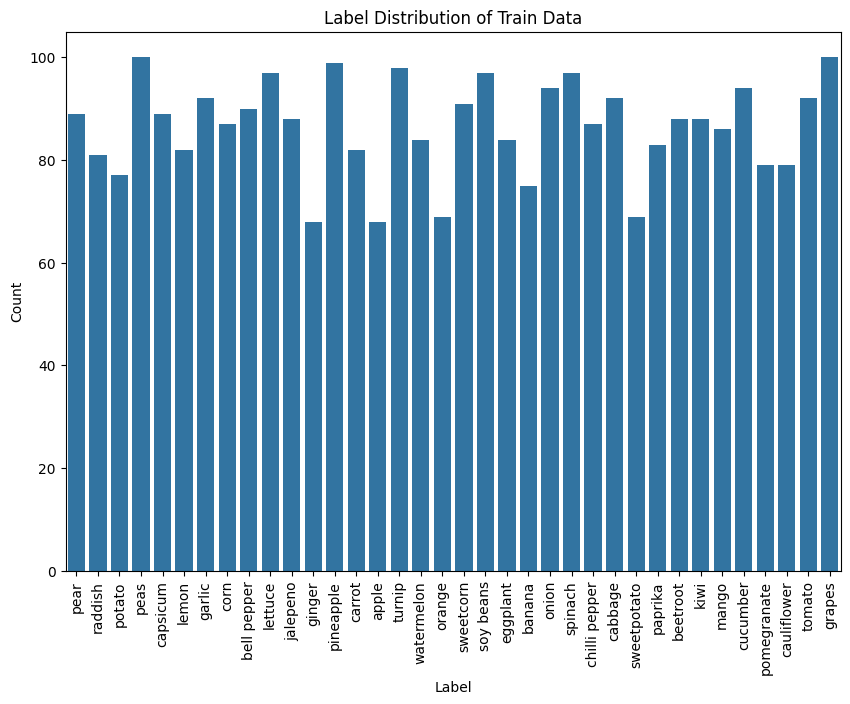

In [14]:
plt.figure(figsize = (10, 7))
plt.title("Label Distribution of Train Data")
plt.xlabel("Label")
plt.ylabel("Count")
sns.countplot(data = train_df, x = "label")
plt.xticks(rotation = 90)
plt.show()

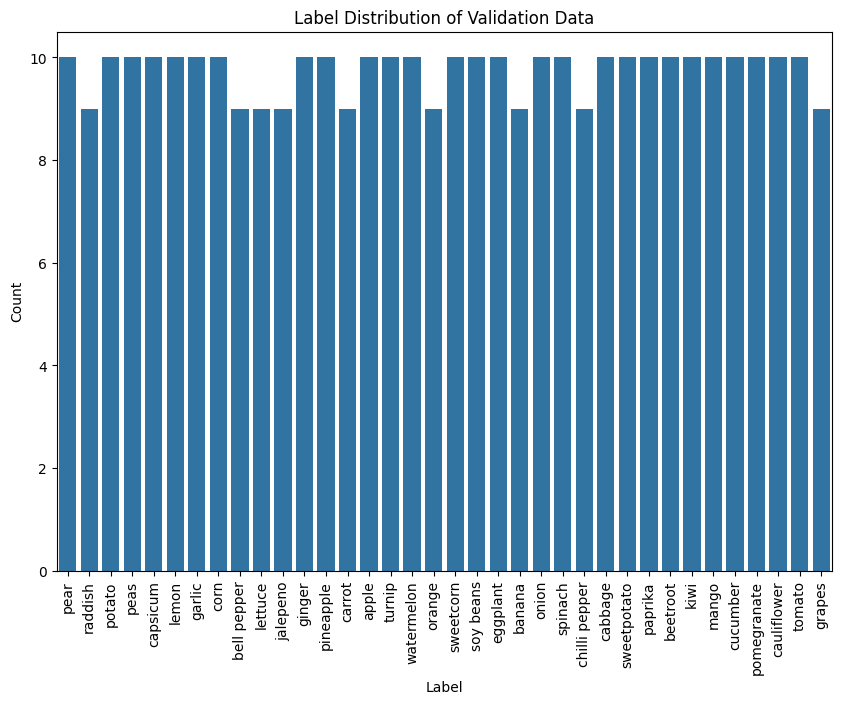

In [15]:
plt.figure(figsize = (10, 7))
plt.title("Label Distribution of Validation Data")
plt.xlabel("Label")
plt.ylabel("Count")
sns.countplot(data = validation_df, x = "label")
plt.xticks(rotation = 90)
plt.show()

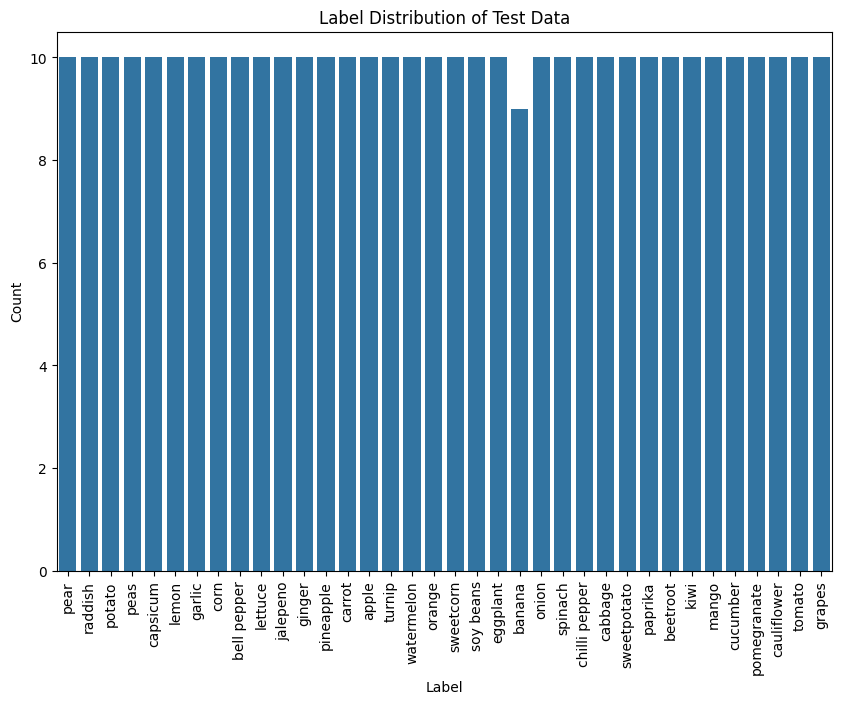

In [16]:
plt.figure(figsize = (10, 7))
plt.title("Label Distribution of Test Data")
plt.xlabel("Label")
plt.ylabel("Count")
sns.countplot(data = test_df, x = "label")
plt.xticks(rotation = 90)
plt.show()

In [17]:
# Let's remind the folder paths.
print(train_path)
print(validation_path)
print(test_path)

/content/data/train
/content/data/validation
/content/data/test


In [18]:
# Setup data inputs
BATCH_SIZE = 32
IMAGE_SHAPE = (224, 224)

# Create ImageDataGenerator objects
train_datagen = ImageDataGenerator(rescale = 1/255.)
validation_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

# Create data flows
print("Train data:")
train_data = train_datagen.flow_from_directory(train_path,
                                               target_size = IMAGE_SHAPE,
                                               shuffle = True,
                                               batch_size = BATCH_SIZE)

print("Validation data:")
validation_data = train_datagen.flow_from_directory(validation_path,
                                                    target_size = IMAGE_SHAPE,
                                                    batch_size = BATCH_SIZE)

print("Test data")
test_data = test_datagen.flow_from_directory(test_path,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE)

Train data:
Found 3115 images belonging to 36 classes.
Validation data:
Found 351 images belonging to 36 classes.
Test data
Found 359 images belonging to 36 classes.


In [19]:
# Create TensorBoard callback
def create_tensorboard_callback(dir_name,
                                experiment_name):
  """
  Creates TensorBoard callback to save model experimentation results
  into related folder.
  """
  log_dir = dir_name + '/' + experiment_name + dt.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
  print(f"Saving TensorBoard log files to {log_dir}")
  return tensorboard_callback

In [20]:
# Let's compare the following two models
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2"
efficientnet_url = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2"

In [21]:
# Let's create a function to create model sequential for us.

def create_model(model_url,
                 num_classes,
                 image_shape):
  """
  Creates Keras Sequential from model URL.

  Args:
    model_url (str): URL of the model taken from Kaggle.
    num_classes (int): Number of classes to be classified.
    image_shape (Tuple): Input shape of images given in tuple format.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pre-trained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = "feature_extractor_layer",
                                           input_shape = image_shape + (3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
  ])
   # Return the model
  return model

In [22]:
# Define number of classes and image shape
NUM_CLASSES = train_data.num_classes
IMAGE_SHAPE = (224, 224)

# Create model
resnet_model = create_model(model_url = resnet_url,
                            num_classes = NUM_CLASSES,
                            image_shape = IMAGE_SHAPE)

# Compile the model
resnet_model.compile(loss = 'CategoricalCrossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs = 10,
                                  callbacks = [create_tensorboard_callback('transfer_learning_exps',
                                                                           'resnet50v2_10epochs')],
                                  validation_data = validation_data)

Saving TensorBoard log files to transfer_learning_exps/resnet50v2_10epochs20250105-055226
Epoch 1/10
 2/98 [..............................] - ETA: 7:10 - loss: 3.8304 - accuracy: 0.0469 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


98/98 [==============================] - 501s 5s/step - loss: 1.6722 - accuracy: 0.5451 - val_loss: 0.5198 - val_accuracy: 0.8689
Epoch 2/10
98/98 [==============================] - 499s 5s/step - loss: 0.6263 - accuracy: 0.8180 - val_loss: 0.3310 - val_accuracy: 0.9288
Epoch 3/10
98/98 [==============================] - 497s 5s/step - loss: 0.4052 - accuracy: 0.8905 - val_loss: 0.2753 - val_accuracy: 0.9316
Epoch 4/10
98/98 [==============================] - 492s 5s/step - loss: 0.2900 - accuracy: 0.9294 - val_loss: 0.2421 - val_accuracy: 0.9487
Epoch 5/10
98/98 [==============================] - 492s 5s/step - loss: 0.2188 - accuracy: 0.9515 - val_loss: 0.2132 - val_accuracy: 0.9630
Epoch 6/10
98/98 [==============================] - 491s 5s/step - loss: 0.1741 - accuracy: 0.9615 - val_loss: 0.2010 - val_accuracy: 0.9573
Epoch 7/10
98/98 [==============================] - 492s 5s/step - loss: 0.1391 - accuracy: 0.9756 - val_loss: 0.1856 - val_accuracy: 0.9658
Epoch 8/10
98/98 [======

In [3]:
# Let's create a function to plot accuracy and loss curves

def plot_accuracy_and_loss(history):
  """
  Plots accuracy and loss graphs seperately for a fitted model.

  Args:
    history: History dictionary of the model.
  """

  # Calculate the epochs
  epochs = range(1, len(history.history['accuracy']) + 1)

  # Plot a figure
  plt.figure(figsize = (14, 6))

  # Plot the accuracy graph
  plt.subplot(1, 2, 1)
  plt.title("Train and Validation Accuracy")
  plt.plot(epochs, history.history['accuracy'], label = "Train Accuracy")
  plt.plot(epochs, history.history['val_accuracy'], label = "Validation Accuracy")
  plt.legend()

  # Plot the loss graph
  plt.subplot(1, 2, 2)
  plt.title("Train and Validation Loss")
  plt.plot(epochs, history.history['loss'], label = "Train Loss")
  plt.plot(epochs, history.history['val_loss'], label = "Validation Loss")
  plt.legend()

In [2]:
resnet_model.evaluate(test_data)

NameError: name 'resnet_model' is not defined